# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Mon 18 Jan** 2021, at 16:00 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/b6358ab6c8dada1382e20c5553931f979c57156c
) (Fri 15 Jan 2021, 23:41).

No uncommitted changes

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, plot_sim_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [5]:
base_params = N_to_1_SimParams(
    sim_duration = 1 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 2,
    rng_seed=1800,
);

In [6]:
sim_data = simulate(base_params);

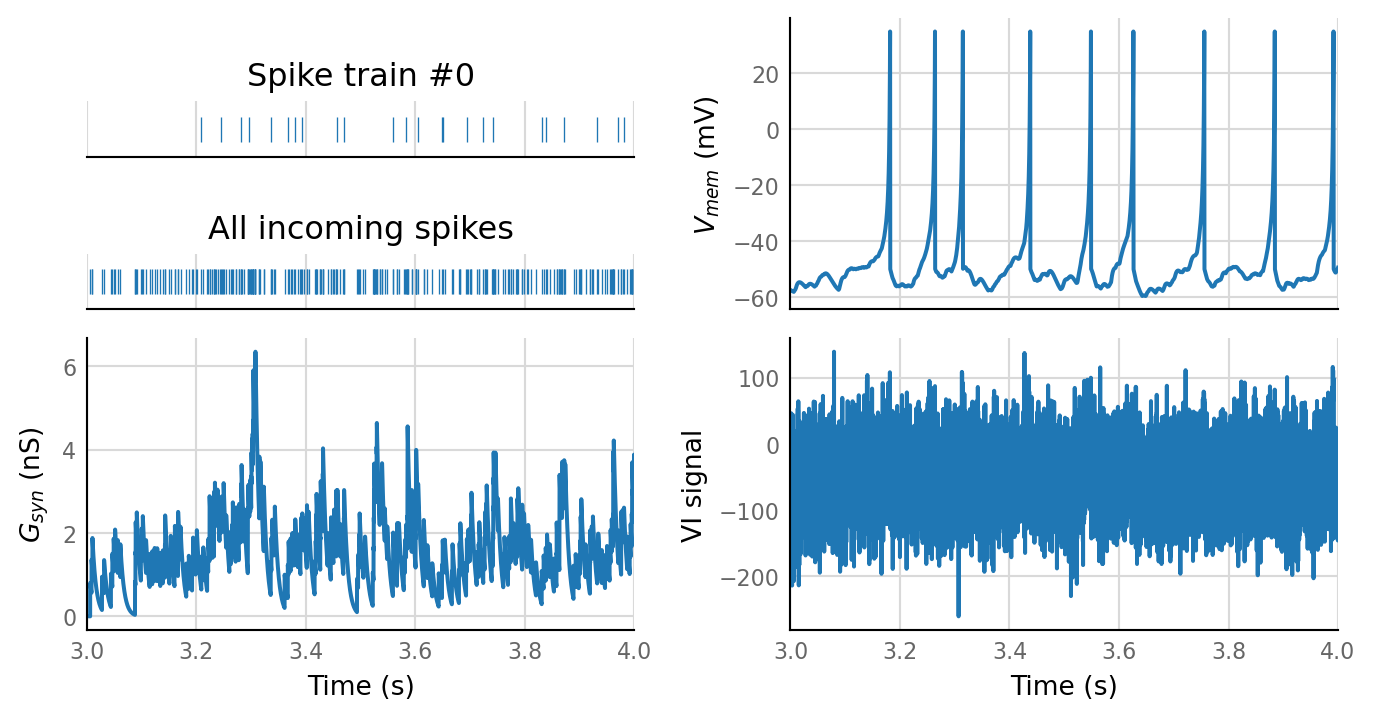

In [7]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

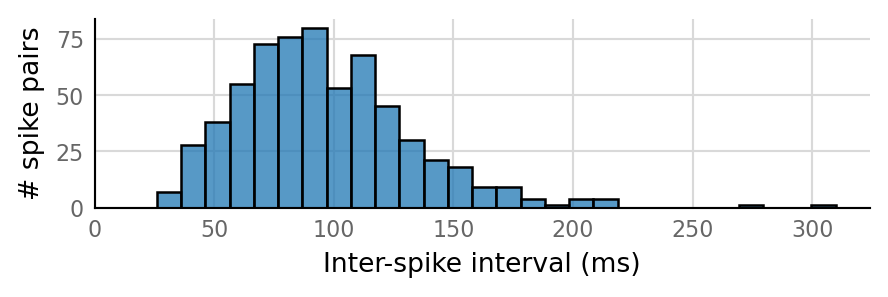

Output spike rate (1 / median ISI): 11 Hz


In [8]:
v.sim.izhikevich_neuron.show_output_spike_stats(sim_data.izh_output);

In [9]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

Testing connections: 100%|██████████| 30/30 [00:02<00:00, 10.65it/s]


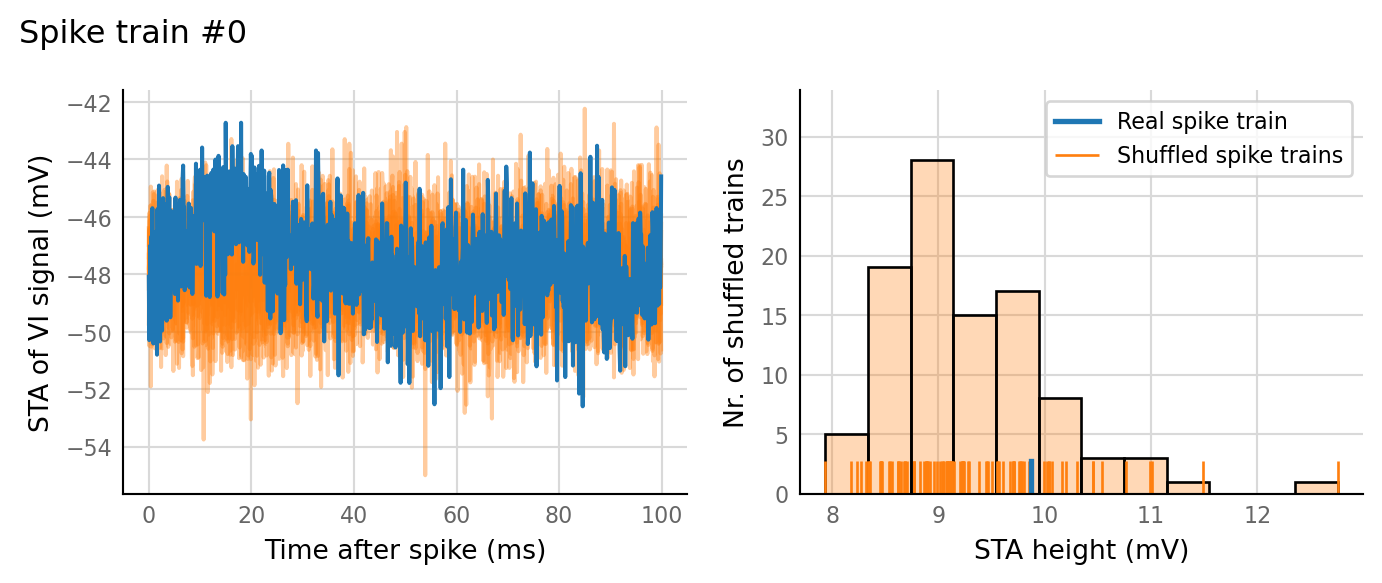

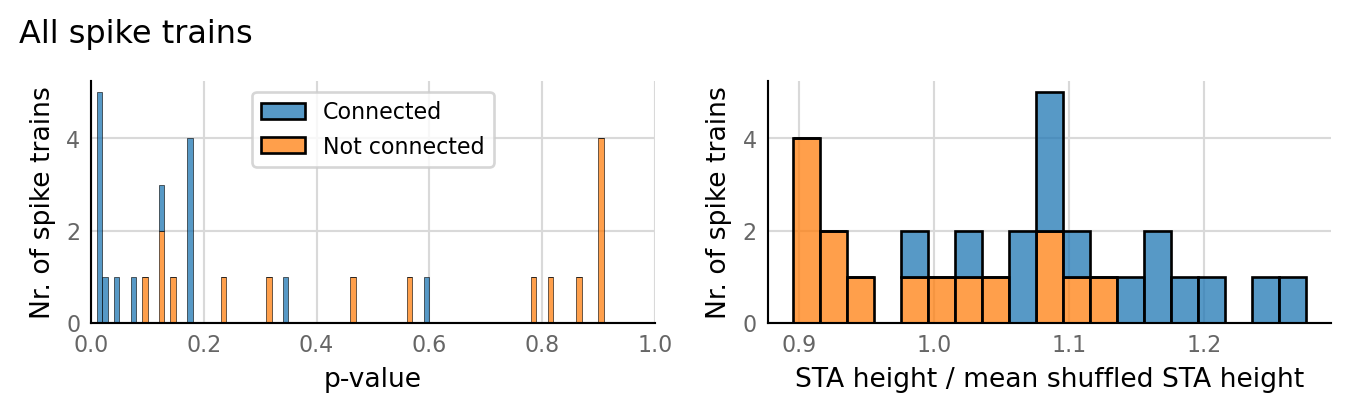

In [10]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

In [11]:
classifs = v.conntest.classification.sweep_threshold(test_summaries, sim_data.is_connected);

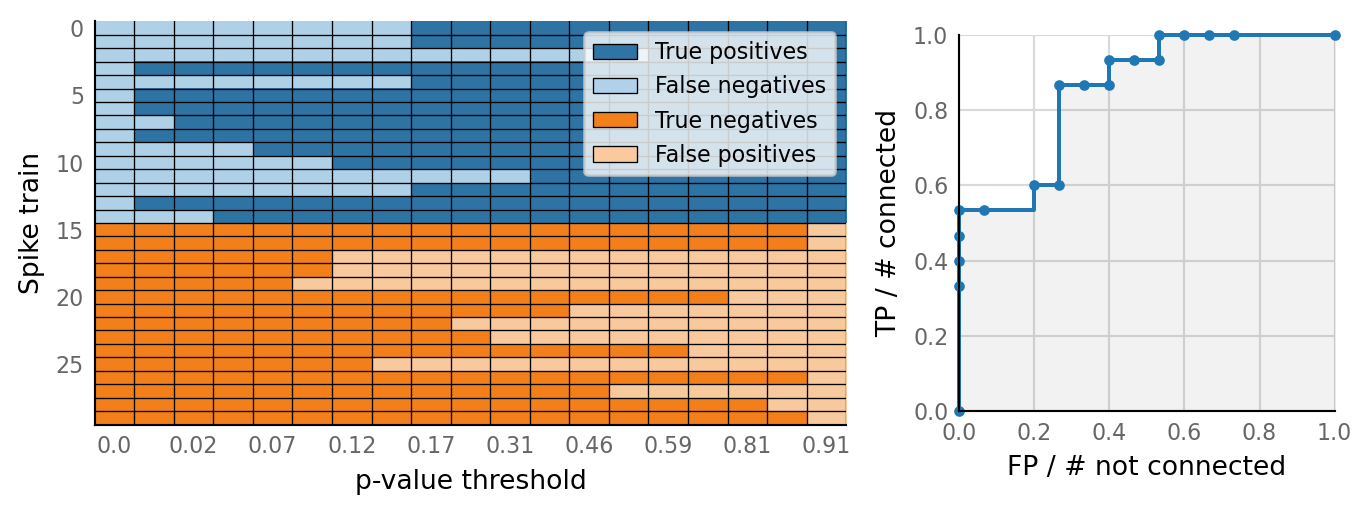

In [12]:
v.N_to_1_experiment.plot_classifications_with_ROC(classifs)

## Vary SNR

(Voltage imaging signal-to-noise ratio).

Remember: recording duration is 1 minute, and median reported VI SNR from the literature is 10.

In [13]:
test_connections = v.N_to_1_experiment.test_connections 
sweep_threshold = v.conntest.classification.sweep_threshold

def sim_and_eval(params):
    with v.time_op("Sim"):
        sim_data = simulate(params)
    test_data, test_summaries = test_connections(sim_data)
    classifs = sweep_threshold(test_summaries, sim_data.is_connected)
    return classifs

In [14]:
SNRs = [1, 2, 4, 8];

In [15]:
from copy import deepcopy

In [16]:
%%time

thr_sweeps = []

for SNR in SNRs:
    print(f"SNR: {SNR}")
    params = deepcopy(base_params)
    params.imaging_spike_SNR = SNR
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)
    print()

SNR: 1
Sim: … (0.45 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 26.00it/s]

SNR: 2
Sim: … (0.642 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 27.03it/s]

SNR: 4
Sim: … (0.482 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 26.33it/s]

SNR: 8
Sim: … (0.482 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 26.27it/s]

Wall time: 6.64 s


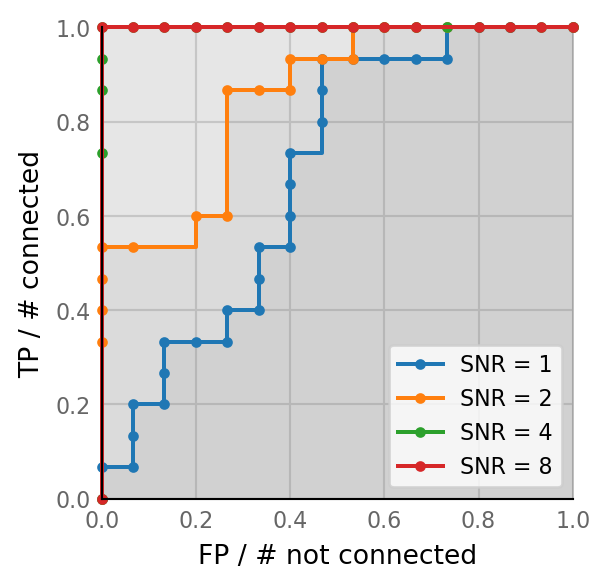

In [17]:
plot_ROC = v.conntest.classification.plot_ROC

ax = None
for i, (SNR, classifs) in enumerate(zip(SNRs, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"SNR = {SNR}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [18]:
def AUC(thr_sweep):
    TPRs = [tr.evaluation.TPR for tr in thr_sweep]
    FPRs = [tr.evaluation.FPR for tr in thr_sweep]
    AUC = 0
    # this is not the same as `np.trapz` e.g.
    for i in range(len(FPRs) - 1):
        AUC += (FPRs[i+1] - FPRs[i]) * TPRs[i]
    return AUC

In [19]:
df = pd.DataFrame(dict(SNR=SNRs, AUC=[AUC(s) for s in thr_sweeps]))

,SNR,AUC
0,1,0.688889
1,2,0.853333
2,4,1.000000
3,8,1.000000


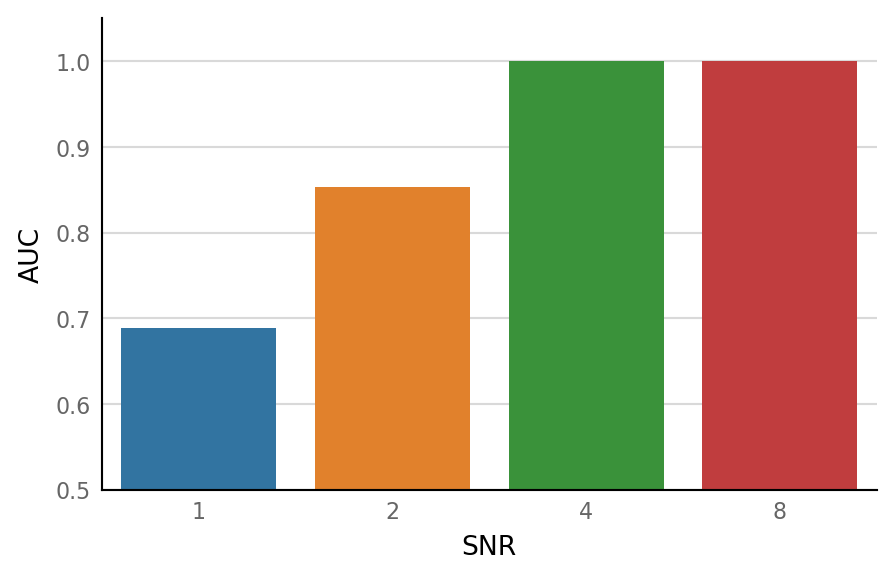

In [20]:
ax = sns.barplot(data=df, x="SNR", y="AUC")
ax.set_ylim(bottom=0.5);

## Vary recording duration

Remember: SNR here is 2, and VI photobleaching has time constant of ~10 minutes.

In [22]:
durations = (
    30 * second,
    1 * minute,
    2 * minute,
    4 * minute,
);

In [42]:
def format_duration(T):
    return f"{T_min:.2G} minute{'' if T_min == 1 else 's'}"

In [43]:
%%time

thr_sweeps = []

for T in durations:
    print(f"Duration: {format_duration(T)}")
    params = deepcopy(base_params)
    params.sim_duration = T
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)
    print()

Duration: 0.5 minutes
Sim: … (0.603 s)
Testing connections: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s]

Duration: 1 minute
Sim: … (0.481 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 24.52it/s]

Duration: 2 minutes
Sim: … (0.528 s)
Testing connections: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s]

Duration: 4 minutes
Sim: … (0.76 s)
Testing connections: 100%|██████████| 30/30 [00:04<00:00,  7.10it/s]

Wall time: 11.1 s


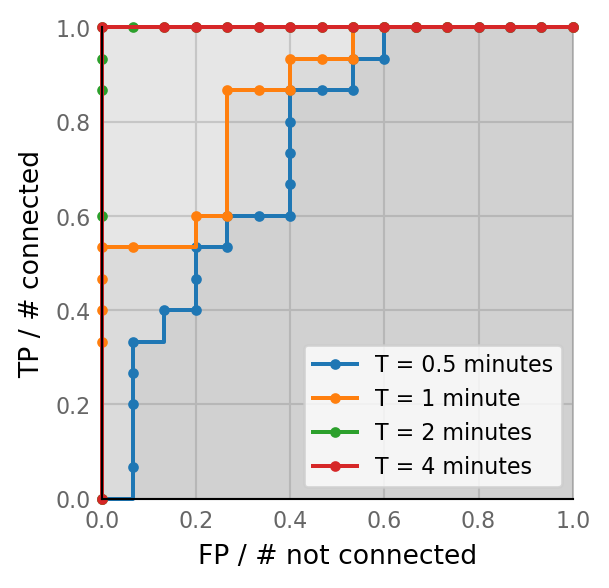

In [44]:
ax = None
for i, (T, classifs) in enumerate(zip(durations, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"T = {format_duration(T)}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [45]:
df = pd.DataFrame(dict(
    recording_duration=[format_duration(T) for T in durations],
    AUC=[AUC(s) for s in thr_sweeps])
)

,recording_duration,AUC
0,0.5 minutes,0.742222
1,1 minute,0.853333
2,2 minutes,1.000000
3,4 minutes,1.000000


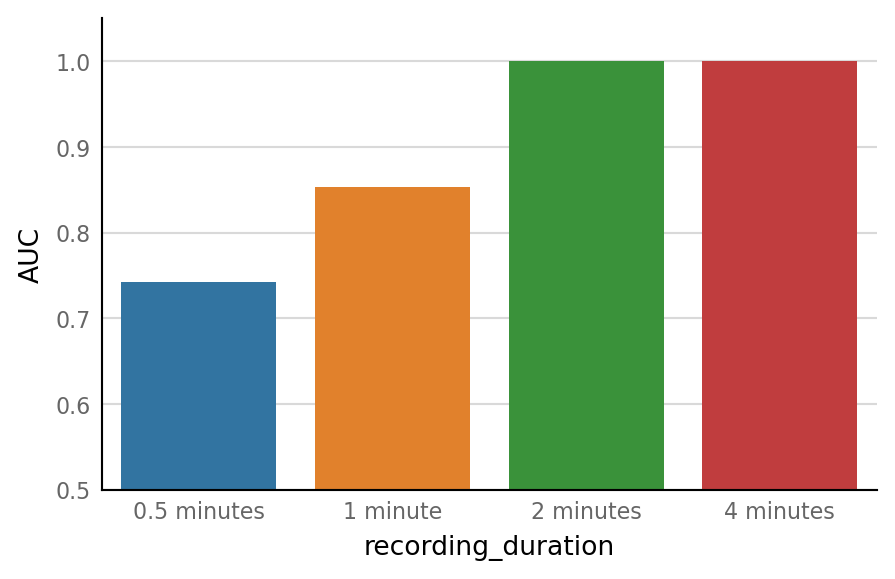

In [46]:
ax = sns.barplot(data=df, x="recording_duration", y="AUC")
ax.set_ylim(bottom=0.5);

## Reproducibility

In [23]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 23:32 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/e92d8ec129733e2f72ad1e227f3564d805396e24
) (Fri 15 Jan 2021, 23:28).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/N_to_1_experiment.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
nptyping             1.4.0
tqdm                 4.56.0


In [24]:
!conda list

# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.2.1              pyh9f0ad1d_0    conda-forge
brotlipy                  0.7.0           py38h294d835_1001    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certifi

pywin32-ctypes            0.2.0                    pypi_0    pypi
pywinpty                  0.5.7            py38h32f6830_1    conda-forge
pyyaml                    5.3.1            py38h294d835_2    conda-forge
pyzmq                     20.0.0           py38h7a0e47e_1    conda-forge
qt                        5.12.9               h5909a2a_3    conda-forge
readme-renderer           28.0                     pypi_0    pypi
regex                     2020.11.13       py38h294d835_1    conda-forge
reproc                    14.2.1               h8ffe710_0    conda-forge
reproc-cpp                14.2.1               h0e60522_0    conda-forge
requests                  2.25.1             pyhd3deb0d_0    conda-forge
requests-toolbelt         0.9.1                    pypi_0    pypi
rfc3986                   1.4.0                    pypi_0    pypi
ruamel_yaml               0.15.80         py38h294d835_1003    conda-forge
scikit-learn              0.24.0           py38ha09990b_0    conda-forge
scip